## Projet final du Kit Data Science 2021
Le projet final du Kit Data Science 2021 porte sur les données du Vendée Globe 2020-2021.

Le projet se déroule 26 octobre au 5 novembre 2021 date limite pour rendre vos projets respectifs.

Les données du dernier Vendée Globe sont disponibles sous la forme de fichiers Excel avec les classements fournis plusieurs fois par jour par les organisateurs de la course. Il y a également une page web avec une fiche technique par voilier qui contient des informations techniques et qu'il est possible de rapprocher des classements.

Il vous appartient de charger les données en Python, de procéder aux préparations nécessaires et d'effectuer les analyses pertinentes de votre choix.

Le rendu sera un notebook Jupyter fourni aux formats ipynb et HTML.

#### Barème sur 15 points :

 Acquisition et chargement des données : 3 points
 
 Préparation des données : 5 points
 
 Analyses et story telling : 7 points
    
#### Exemples de traitements et d'analyses :

 Récupération des fichiers Excel avec les classements
    
   Mettre en place une copie locale des fichiers Excel afin de ne pas les
   recharger à chaque run.
    
   Vers la fin de la course le format des fichiers Excel change avec les 
   arrivées des voiliers : il est possible de s'arrêter juste avant.
    
  Extraction des caractéristiques techniques de chacun des voiliers.
    
  Rapprochement des données des voiliers avec celle des classements.
    
  Corrélation et régression linéaire entre le classement (rang) et la vitesse 
  utile (VMG) des voiliers.
    
  Impact de la présence d'un foil sur le classement et la vitesse des voiliers.
    
  Visualisation de la distance parcourue par voilier.
    
  Cartes avec les routes d'un ou plusieurs voiliers.
    
  Analyses de séries temporelles.
    
  Application d'algorithmes statistiques ou de machine learning.
  
  etc.

#### Sources des données

  Page web donnant accès aux fichiers Excel des classements du Vendée Globe : https://www.vendeeglobe.org/fr/classement
    
  Page web avec les fiches techniques des voiliers du Vendée Globe : https://www.vendeeglobe.org/fr/glossaire
    
  Site web donnant accès à des fichiers avec les formes géométriques des côtes : https://www.naturalearthdata.com/ (ou bien 
  utilisez les librairies plotly ou ipyleaflet pour produire des cartes)
    
  etc.

#### Questions/Réponses

Les questions et réponses seront publiées ci-après au fil de l'eau :

  Qu'est-ce qu'un foil ? https://www.vendeeglobe.org/fr/actualites/19755/quels-foils-pour-gagner-le-vendee-globe La présence 
  d'un foil est indiqué dans l'attribut "Nombre de dérives" dans les fiches techniques des voiliers.
    
  S'agit-il d'un travail individuel ou collectif ? Il s'agit bien d'un travail individuel.
  
  

### Avertissement

Vous devez publier votre notebook exécuté aux formats ipynb et HTML sur votre github avant le vendredi 5 novembre 2021 à 23h59 et lorsque c'est fait envoyer une notification par email avec le lien du projet à l'adresse contact(at)yotta-conseil.fr

Bon projet !

#### Dans le cadre du projet Kit Data Science, nous allons analyser les données du dernier Vendée Globe.
#### Les données ciblées sont le classement des skipper et les caractéristiques techniques de leur voiliers.
#### L'analyse sera organisée suivant le plan ci-dessous :

**1) Exploitation des classements**
- Téléchargement des fichiers excel
- Concaténation de tous les fichiers afin d'avoir un dataframe global
- Mise en forme du dataframe afin de le rendre exploitable


**2) Exploitation des caractéristiques techniques des voiliers**
- Téléchargement des données techniques des voiliers
- Mise en forme du dataframe obtenue afin de le rendre exploitable

**3) Jointure des classements avec les caractéristiques techniques des voiliers**

**4) Statistiques**
- Liste des skippers ayant abandonnés la course
- Affichage des 5 premiers skippers en fonction de la vitesse Last_report jusqu'au 27 Janvier 2021**
- Affichage des 5 premiers skippers en fonction de la VMG last report jusqu'au 27 Janvier 2021**
- Affichage des skippers en fonction de leur classement moyen jusqu'au 27 Janvier 2021**

**5) Visualisations**
- Visualisation du rang pour 6 skippers sur la durée de la course jusqu'au 27 Janvier 2021**
- Visualisation du rang en fonction du déplacement du poids par le voilier**
- Impact du foil sur la VMG Last Report moyenne**
- Corrélation et régression linéaire entre le rang moyen et la VMG last report jusqu'au 27 Janvier**
- Affichage du parcours de Yannick Bestaven, vainqueur de la course**






### Importation des librairies
***

In [709]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
from urllib import request
import shutil
import datetime
import seaborn as sns

!pip install folium

import folium
import folium.plugins as plg
import matplotlib.pyplot as plt

### 1) Exploitation des classements
***

**Téléchargement des classements au format excel**

In [713]:
#URL utilisé pour télécharger les classements en format excel
url = "https://www.vendeeglobe.org/fr/classement"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
links = soup.find_all('option')[:0:-1]
links = list(dict.fromkeys(links)) #présence de 3 doublons de date, passage par un dictionnaire et retour vers une liste pour les supprimer

for t in links :
    suffixe = t['value']+".xlsx"
    url_2 = 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_'+ suffixe
    
    r = requests.get(url_2, allow_redirects=True)
    open(suffixe, 'wb').write(r.content) 



In [ ]:
#Les fichiers excels n'étant pas exploitables par python, il faut les ouvrir et les fermer pour les rendre lisibles par la suite
#Cette fonction a été rédigée par un collègue du MS BGD

import xlwings

def xlsx_broken(file):
    excel_app = xlwings.App(visible=False)
    excel_book = excel_app.books.open(file)
    excel_book.save()
    excel_book.close()
    excel_app.quit()
    return

**Concaténation des fichiers excels et ajout de la colonne date**

In [728]:
links_trimmed = links[1:483] #la liste est réduite en commençant par 20201108_140000.xlsx, première date à laquelle le classement est rempli.
                            #Elle se termine par 20210127_140000.xlsx dernière date avant l'arrivée du premier candidat et du changement de format des fichiers excels

rows_discarded = [0,1,2,3,4,38,39,40,41] #numéro des lignes à supprimer lors de la lecture d'un fichier excel de classement



def vg_global():
    df = pd.DataFrame()
    
    for t in links_trimmed :
        filename = t["value"]+".xlsx"
        date = t.text.strip('-').strip()   
        excel = pd.read_excel(filename,header=None,skiprows=rows_discarded)
        excel[0]= excel[0].replace(np.nan,date)
        df = df.append(excel, ignore_index=True)
    return df

vg = vg_global()

#sauvegarde des fichiers concaténés 
vg.to_pickle("vg_concat.pkl")

vg.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,2020-11-08 14:00:00,1,\nFRA 18,Louis Burton\nBureau Vallée 2,15:30 FR\n,46°24.46'N,01°50.48'W,241°,17.7 kts,17.5 kts,...,357°,0.0 kts,0.0 kts,2788.0 nm,201°,0.3 kts,0.3 kts,6.1 nm,24293.9 nm,0.0 nm
1,2020-11-08 14:00:00,2,\nMON 10,Boris Herrmann\nSeaexplorer - Yacht Club De Mo...,15:31 FR\n1min,46°24.34'N,01°49.82'W,241°,11.1 kts,10.9 kts,...,357°,0.0 kts,0.0 kts,2787.9 nm,196°,0.3 kts,0.2 kts,6.0 nm,24294.2 nm,0.4 nm
2,2020-11-08 14:00:00,3,\nFRA 8,Jérémie Beyou\nCharal,15:30 FR\n,46°24.91'N,01°49.99'W,244°,15.5 kts,15.5 kts,...,357°,0.0 kts,0.0 kts,2788.5 nm,199°,0.2 kts,0.2 kts,5.5 nm,24294.3 nm,0.5 nm
3,2020-11-08 14:00:00,4,\nFRA 59,Thomas Ruyant\nLinkedOut,15:30 FR\n,46°24.71'N,01°49.68'W,244°,13.2 kts,13.1 kts,...,357°,0.0 kts,0.0 kts,2788.3 nm,196°,0.2 kts,0.2 kts,5.6 nm,24294.5 nm,0.6 nm
4,2020-11-08 14:00:00,5,\nFRA 53,Maxime Sorel\nV And B Mayenne,15:30 FR\n,46°24.59'N,01°49.56'W,246°,10.9 kts,10.9 kts,...,357°,0.0 kts,0.0 kts,2788.1 nm,195°,0.8 kts,0.7 kts,5.8 nm,24294.5 nm,0.6 nm


In [729]:
#relecture à partir du fichier excel sauvegardé précédemment afin de ne pas répéter l'étape
vg= pd.read_pickle("vg_concat.pkl")

#suppression des lignes vides et reset de l'index
vg_raw = vg #une trace du dataframe est gardée avant modification
vg = vg.dropna(subset=[4]).reset_index(drop=True)

vg

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,2020-11-08 14:00:00,1,\nFRA 18,Louis Burton\nBureau Vallée 2,15:30 FR\n,46°24.46'N,01°50.48'W,241°,17.7 kts,17.5 kts,...,357°,0.0 kts,0.0 kts,2788.0 nm,201°,0.3 kts,0.3 kts,6.1 nm,24293.9 nm,0.0 nm
1,2020-11-08 14:00:00,2,\nMON 10,Boris Herrmann\nSeaexplorer - Yacht Club De Mo...,15:31 FR\n1min,46°24.34'N,01°49.82'W,241°,11.1 kts,10.9 kts,...,357°,0.0 kts,0.0 kts,2787.9 nm,196°,0.3 kts,0.2 kts,6.0 nm,24294.2 nm,0.4 nm
2,2020-11-08 14:00:00,3,\nFRA 8,Jérémie Beyou\nCharal,15:30 FR\n,46°24.91'N,01°49.99'W,244°,15.5 kts,15.5 kts,...,357°,0.0 kts,0.0 kts,2788.5 nm,199°,0.2 kts,0.2 kts,5.5 nm,24294.3 nm,0.5 nm
3,2020-11-08 14:00:00,4,\nFRA 59,Thomas Ruyant\nLinkedOut,15:30 FR\n,46°24.71'N,01°49.68'W,244°,13.2 kts,13.1 kts,...,357°,0.0 kts,0.0 kts,2788.3 nm,196°,0.2 kts,0.2 kts,5.6 nm,24294.5 nm,0.6 nm
4,2020-11-08 14:00:00,5,\nFRA 53,Maxime Sorel\nV And B Mayenne,15:30 FR\n,46°24.59'N,01°49.56'W,246°,10.9 kts,10.9 kts,...,357°,0.0 kts,0.0 kts,2788.1 nm,195°,0.8 kts,0.7 kts,5.8 nm,24294.5 nm,0.6 nm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13698,2021-01-27 14:00:00,21,\nFRA 71,Manuel Cousin\nGroupe Sétin,14:30 FR\n,24°00.42'S,26°47.83'W,347°,8.9 kts,7.9 kts,...,355°,13.7 kts,13.0 kts,41.1 nm,351°,12.9 kts,12.0 kts,310.4 nm,4521.7 nm,4441.2 nm
13699,2021-01-27 14:00:00,22,\nFRA 50,Miranda Merron\nCampagne de France,14:30 FR\n,26°10.76'S,26°01.91'W,348°,10.9 kts,9.9 kts,...,349°,11.8 kts,10.8 kts,35.5 nm,352°,10.5 kts,9.8 kts,252.0 nm,4639.1 nm,4558.6 nm
13700,2021-01-27 14:00:00,23,\nFRA 83,Clément Giraud\nCompagnie du lit - Jiliti,14:30 FR\n,26°00.07'S,29°30.27'W,7°,11.0 kts,10.9 kts,...,1°,10.1 kts,9.8 kts,30.3 nm,340°,9.6 kts,7.9 kts,230.4 nm,4674.6 nm,4594.1 nm
13701,2021-01-27 14:00:00,24,\nFRA 72,Alexia Barrier\nTSE - 4myplanet,14:30 FR\n,48°09.05'S,53°51.45'W,25°,10.1 kts,10.0 kts,...,23°,9.1 kts,9.0 kts,27.3 nm,29°,11.4 kts,11.4 kts,273.7 nm,6341.5 nm,6260.9 nm


**Mise en forme du dataframe pour le rendre exploitable**

In [730]:
#Transformation de la première colonne en datetime
vg.rename(columns={0 : "Date"},inplace=True)
vg["Date"]=pd.to_datetime (vg["Date"], format = '%Y-%m-%d %H:%M:%S')

#Affectation de la colonne Rank
vg.rename(columns={1 : "Rank"},inplace=True)
vg["Rank"] = vg["Rank"].astype("int")

#Séparation de la colonne des nationalités et numéro du voile
vg['Nationality'] = vg[2].str.split(' ').str[0].str.replace('\n', '')
vg['Sail'] = vg[2].str.split(' ').str[1].apply(int)

vg['Nationality'] = vg['Nationality'].replace(['FRFRA'],'FRA') #Présence d'une nationatlité FRFRA remplacée par FRA

#Séparation de la colonne des skipper et crew
vg['Nom du Skipper'] = vg[3].str.split('\n').str[0]
vg['Crew'] = vg[3].str.split('\n').str[1].str.title() #mise en forme commune des noms des voiliers car certaines différences apparaissent pour le même nom

#Mise à jour des Heures FR avec prise en compte des deltas
vg.rename(columns={4 : "Heure_FR"},inplace=True)

heure=vg["Heure_FR"].str.extract('(.*) FR\n(\d*\w*)')
heure[1]=heure[1].apply(lambda x: '0min' if x=='' else x)
vg["Heure_FR"] = (pd.to_datetime(heure[0]+':00',format='%H:%M:%S')-pd.to_timedelta(heure[1]) ).dt.strftime('%H:%M:%S')

# Conversion des Latitudes et Longitudes en DMS à l'aide d'une fonction 
def coordinates_conversion(x):
    direction = {'N':1, 'S':-1, 'E': 1, 'W':-1}
    new = x.replace(u'°',' ').replace('\'',' ').replace('.',' ')
    new = new.split()
    new_dir = new.pop()
    new.extend([0,0,0])
    return (int(new[0])+int(new[1])/60.0+int(new[2])/3600.0) * direction[new_dir]

vg.rename(columns={5 : "Latitude", 6 : "Longitude"},inplace=True)


vg["Latitude"] = vg["Latitude"].apply(coordinates_conversion)
vg["Longitude"] = vg["Longitude"].apply(coordinates_conversion)

# On remplace les colonnes 7 à 20 par leurs intitulés et on supprimme les unités
columns_data = ["Cap 30_deg", "Vitesse 30_kts", "VMG 30_kts","Distance 30_kts",
                  "Cap last report_deg", "Vitesse last report_kts", "VMG last report_kts","Distance last report_nm", 
                  "Cap 24h_deg", "Vitesse 24h_kts", "VMG 24h_kts","Distance 24h_nm","DTF_nm", "DTL_nm"]

vg.rename(columns=dict(zip(vg.columns[7:21], columns_data)),inplace=True)

vg[columns_data] = vg[columns_data].apply(lambda x: x.replace(re.compile('[a-z]+|°'), '')).apply(pd.to_numeric)

#Suppression des colonnes 2 et 3
vg = vg.drop(2, axis=1)
vg = vg.drop(3, axis=1)

#Mise en ordre des colonnes
vg = vg[["Date","Rank", "Nationality", "Sail", "Nom du Skipper", "Crew","Heure_FR", "Latitude", "Longitude", *columns_data]]

#sauvegarde des fichiers après mise en forme 
vg.to_pickle("vg_clean.pkl")

vg

,Date,Rank,Nationality,Sail,Nom du Skipper,Crew,Heure_FR,Latitude,Longitude,Cap 30_deg,...,Cap last report_deg,Vitesse last report_kts,VMG last report_kts,Distance last report_nm,Cap 24h_deg,Vitesse 24h_kts,VMG 24h_kts,Distance 24h_nm,DTF_nm,DTL_nm
0,2020-11-08 14:00:00,1,FRA,18,Louis Burton,Bureau Vallée 2,15:30:00,46.412778,-1.846667,241,...,357,0.0,0.0,2788.0,201,0.3,0.3,6.1,24293.9,0.0
1,2020-11-08 14:00:00,2,MON,10,Boris Herrmann,Seaexplorer - Yacht Club De Monaco,15:30:00,46.409444,-1.839444,241,...,357,0.0,0.0,2787.9,196,0.3,0.2,6.0,24294.2,0.4
2,2020-11-08 14:00:00,3,FRA,8,Jérémie Beyou,Charal,15:30:00,46.425278,-1.844167,244,...,357,0.0,0.0,2788.5,199,0.2,0.2,5.5,24294.3,0.5
3,2020-11-08 14:00:00,4,FRA,59,Thomas Ruyant,Linkedout,15:30:00,46.419722,-1.835556,244,...,357,0.0,0.0,2788.3,196,0.2,0.2,5.6,24294.5,0.6
4,2020-11-08 14:00:00,5,FRA,53,Maxime Sorel,V And B Mayenne,15:30:00,46.416389,-1.832222,246,...,357,0.0,0.0,2788.1,195,0.8,0.7,5.8,24294.5,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13698,2021-01-27 14:00:00,21,FRA,71,Manuel Cousin,Groupe Sétin,14:30:00,-24.011667,-26.806389,347,...,355,13.7,13.0,41.1,351,12.9,12.0,310.4,4521.7,4441.2
13699,2021-01-27 14:00:00,22,FRA,50,Miranda Merron,Campagne De France,14:30:00,-26.187778,-26.041944,348,...,349,11.8,10.8,35.5,352,10.5,9.8,252.0,4639.1,4558.6
13700,2021-01-27 14:00:00,23,FRA,83,Clément Giraud,Compagnie Du Lit - Jiliti,14:30:00,-26.001944,-29.507500,7,...,1,10.1,9.8,30.3,340,9.6,7.9,230.4,4674.6,4594.1
13701,2021-01-27 14:00:00,24,FRA,72,Alexia Barrier,Tse - 4Myplanet,14:30:00,-48.151389,-53.862500,25,...,23,9.1,9.0,27.3,29,11.4,11.4,273.7,6341.5,6260.9


In [731]:
#Liste des colonnes 
vg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13703 entries, 0 to 13702
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     13703 non-null  datetime64[ns]
 1   Rank                     13703 non-null  int32         
 2   Nationality              13703 non-null  object        
 3   Sail                     13703 non-null  int64         
 4   Nom du Skipper           13703 non-null  object        
 5   Crew                     13703 non-null  object        
 6   Heure_FR                 13703 non-null  object        
 7   Latitude                 13703 non-null  float64       
 8   Longitude                13703 non-null  float64       
 9   Cap 30_deg               13703 non-null  int64         
 10  Vitesse 30_kts           13703 non-null  float64       
 11  VMG 30_kts               13703 non-null  float64       
 12  Distance 30_kts          13703 n

### 2) Exploitation des caractéristiques techniques des voiliers
***

**Téléchargement des données techniques des voiliers**



In [732]:
url2 = "https://www.vendeeglobe.org/fr/glossaire"
response2 = requests.get(url2)
soup = BeautifulSoup(response2.text, 'html.parser')   

car_name = soup.findAll("div", class_="boats-list__infos")
car_tech = soup.findAll("div", class_="boats-list__popup-infos")

tech_store = []
names_store = {}

for names in car_name :
    names_store.setdefault('Nom du Skipper',[]).append(names.find('span', class_="boats-list__skipper-name").text.title())

for tech in car_tech :

    nickname = tech.find('h3', class_="boats-list__popup-title").text
    team = {'Nom du Voilier': nickname}
    
    for spec in tech.find('ul', class_='boats-list__popup-specs-list').find_all('li') :
        spec = spec.text.split(":")
        team[spec[0]] = spec[1]
    
    tech_store.append(team)

#Conversion en Dataframe
vg_carac = pd.DataFrame(tech_store)
names_df = pd.DataFrame(names_store)


In [733]:
#Certains noms de Skippers figurant dans les caractéristiques techniques sont différents de ceux du classement
names_df.loc[names_df['Nom du Skipper'].str.contains('Sam'),'Nom du Skipper']='Samantha Davies'
names_df.loc[names_df['Nom du Skipper'].str.contains('Alan'),'Nom du Skipper']='Alan Roura'
names_df.loc[names_df['Nom du Skipper'].str.contains('Arnaud'),'Nom du Skipper']='Arnaud Boissieres'    
names_df['Nom du Skipper'] = names_df['Nom du Skipper'].str.title()

#Concaténation des noms des skippers issus du glossaire avec les caractéristiques techniques
vg_tech = pd.concat([names_df, vg_carac], axis=1)

#suppression d'espace dans les intitulés de colonnes
vg_tech.columns = vg_tech.columns.str.strip()

vg_tech

,Nom du Skipper,Nom du Voilier,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,Fabrice Amedeo,NEWREST - ART & FENÊTRES,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",7 t,foils,29 m,monotype,320 m2,570 m2
1,Romain Attanasio,PURE - Best Western®,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,"18,28m","5,80m","4,50m",9t,2,28m,acier forgé,280 m2,560 m2
2,Alexia Barrier,TSE - 4MYPLANET,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeu...",Marc Lombard,MAG France,01 Mars 1998,"18,28m","5,54m","4,50m",9t,2,29 m,acier,260 m2,580 m2
3,Yannick Bestaven,Maître CoQ IV,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28 m","5,80 m","4,50 m",8 t,foils,29 m,acier mécano soudé,310 m2,550 m2
4,Jérémie Beyou,CHARAL,08,NaN,VPLP,CDK Technologies,18 Août 2018,"18,28 m","5,85 m","4,50 m",8t,foils,29 m,acier,320 m2,600 m2
5,Arnaud Boissieres,LA MIE CÂLINE - ARTISANS ARTIPÔLE,FRA 14,"Ecover3, Président, Gamesa, Kilcullen Voyager...",Owen Clarke Design LLP - Clay Oliver,Hakes Marine - Mer Agitée,03 Août 2007,"18,28 m","5,65 m","4,50 m","7,9 tonnes",foils,29 m,basculante avec vérin,300 m²,610 m²
6,Louis Burton,BUREAU VALLEE 2,18,Banque Populaire VIII,Verdier - VPLP,CDK Technologies,09 Juin 2015,"18,28 m","5,80 m","4,50 m","7,6 t",foils,28 m,acier,300 m2,600 m2
7,Didac Costa,ONE PLANET ONE OCEAN,ESP 33,Kingfisher - Educacion sin Fronteras - Forum ...,Owen Clarke Design,Martens Yachts,02 Février 2000,"18,28 m","5,30 m","4,50 m","8,9 t",2,26 m,acier,240 m2,470 m2
8,Manuel Cousin,GROUPE SÉTIN,FRA 71,"Paprec-Virbac2, Estrella Damm, We are Water, ...",Bruce Farr Yacht Design,Southern Ocean Marine (Nouvelle-Zélande),02 Février 2007,"18,28 m","5,80 m","4,50 m",9 t,2 asymétriques,"28,50",basculante sur vérin hydraulique,270 m2,560 m2
9,Clarisse Cremer,BANQUE POPULAIRE X,FRA30,Macif - SMA,Verdier - VPLP,CDK - Mer Agitée,01 Mars 2011,"18,28 m","5,70 m","4,5 m","7,7 t",2,29 m,acier forgé,340 m2,570 m2


**Mise en forme du tableau des caractéristiques des voiliers**



In [734]:
#Modification du format de la date de lancement
#vg_tech['Date de lancement']=pd.to_datetime(vg_tech_tech['Date de lancement'], format="%d %B %Y")

#Changement du format des valeur et suppression de leur unités
vg_tech['Longueur'] = vg_tech['Longueur'].apply(lambda x : (str(x).replace(',', '.'))[0:-1])
vg_tech['Largeur'] = vg_tech['Largeur'].apply(lambda x : (str(x).replace(',', '.'))[0:-1])
vg_tech["Tirant d'eau"] = vg_tech["Tirant d'eau"].apply(lambda x : (str(x).replace(',', '.'))[0:-1])
vg_tech["Déplacement (poids)"] = vg_tech["Déplacement (poids)"].apply(lambda x : ((str(x).replace(',', '.')).replace('tonne',''))[0:-1])
vg_tech["Hauteur mât"] = vg_tech["Hauteur mât"].apply(lambda x : ((str(x).replace(',', '.')).replace(' ', ''))[0:-1])
vg_tech["Surface de voiles au près"] = vg_tech["Surface de voiles au près"].apply(lambda x : ((str(x).replace(',', '.')).replace(' ', ''))[0:-2])
vg_tech["Surface de voiles au portant"] = vg_tech["Surface de voiles au portant"].apply(lambda x : (str(x).replace(',', '.'))[0:-2])

vg_tech["Déplacement (poids)"] = vg_tech["Déplacement (poids)"].str.strip()

#Après recherche, le foiler et le foil sont semblables
vg_tech.loc[vg_tech['Nombre de dérives'].str.contains('foiler'),'Nombre de dérives']='foils'
vg_tech['Nombre de dérives'] = vg_tech['Nombre de dérives'].str.strip()

#Passage des valeurs au format numérique
pd.to_numeric(vg_tech["Longueur"], errors='raise')
pd.to_numeric(vg_tech["Largeur"], errors='raise')
pd.to_numeric(vg_tech["Tirant d'eau"], errors='raise')
pd.to_numeric(vg_tech["Déplacement (poids)"], errors='coerce')
pd.to_numeric(vg_tech["Hauteur mât"], errors='raise')
pd.to_numeric(vg_tech["Surface de voiles au près"], errors='raise')
pd.to_numeric(vg_tech["Surface de voiles au portant"], errors='raise')

vg_tech["Déplacement (poids)"]=vg_tech["Déplacement (poids)"].replace(['N','n'], np.nan)

#sauvegarde de vg_tech
vg_tech.to_pickle("vgtech_clean.pkl")

vg_tech

,Nom du Skipper,Nom du Voilier,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,Fabrice Amedeo,NEWREST - ART & FENÊTRES,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,18.28,5.85,4.50,7,foils,29,monotype,320,570
1,Romain Attanasio,PURE - Best Western®,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,18.28,5.80,4.50,9,2,28,acier forgé,280,560
2,Alexia Barrier,TSE - 4MYPLANET,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeu...",Marc Lombard,MAG France,01 Mars 1998,18.28,5.54,4.50,9,2,29,acier,260,580
3,Yannick Bestaven,Maître CoQ IV,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,18.28,5.80,4.50,8,foils,29,acier mécano soudé,310,550
4,Jérémie Beyou,CHARAL,08,NaN,VPLP,CDK Technologies,18 Août 2018,18.28,5.85,4.50,8,foils,29,acier,320,600
5,Arnaud Boissieres,LA MIE CÂLINE - ARTISANS ARTIPÔLE,FRA 14,"Ecover3, Président, Gamesa, Kilcullen Voyager...",Owen Clarke Design LLP - Clay Oliver,Hakes Marine - Mer Agitée,03 Août 2007,18.28,5.65,4.50,7.9,foils,29,basculante avec vérin,300,610
6,Louis Burton,BUREAU VALLEE 2,18,Banque Populaire VIII,Verdier - VPLP,CDK Technologies,09 Juin 2015,18.28,5.80,4.50,7.6,foils,28,acier,300,600
7,Didac Costa,ONE PLANET ONE OCEAN,ESP 33,Kingfisher - Educacion sin Fronteras - Forum ...,Owen Clarke Design,Martens Yachts,02 Février 2000,18.28,5.30,4.50,8.9,2,26,acier,240,470
8,Manuel Cousin,GROUPE SÉTIN,FRA 71,"Paprec-Virbac2, Estrella Damm, We are Water, ...",Bruce Farr Yacht Design,Southern Ocean Marine (Nouvelle-Zélande),02 Février 2007,18.28,5.80,4.50,9,2 asymétriques,28.5,basculante sur vérin hydraulique,270,560
9,Clarisse Cremer,BANQUE POPULAIRE X,FRA30,Macif - SMA,Verdier - VPLP,CDK - Mer Agitée,01 Mars 2011,18.28,5.70,4.5,7.7,2,29,acier forgé,340,570


### 3) Jointure des classements avec les caractéristiques techniques des voiliers
***

**La fusion des deux Dataframe se fait à l'aide de la colonne Nom du Skipper**

In [735]:
vg_merged = pd.merge(vg, vg_tech, on="Nom du Skipper",how="left")

vg_merged.to_pickle("vg_merged.pkl")

vg_merged.head()

,Date,Rank,Nationality,Sail,Nom du Skipper,Crew,Heure_FR,Latitude,Longitude,Cap 30_deg,...,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,2020-11-08 14:00:00,1,FRA,18,Louis Burton,Bureau Vallée 2,15:30:00,46.412778,-1.846667,241,...,09 Juin 2015,18.28,5.80,4.50,7.6,foils,28,acier,300,600
1,2020-11-08 14:00:00,2,MON,10,Boris Herrmann,Seaexplorer - Yacht Club De Monaco,15:30:00,46.409444,-1.839444,241,...,07 Août 2015,18.28,5.70,4.50,7.6,foils,29,acier,290,490
2,2020-11-08 14:00:00,3,FRA,8,Jérémie Beyou,Charal,15:30:00,46.425278,-1.844167,244,...,18 Août 2018,18.28,5.85,4.50,8,foils,29,acier,320,600
3,2020-11-08 14:00:00,4,FRA,59,Thomas Ruyant,Linkedout,15:30:00,46.419722,-1.835556,244,...,03 Septembre 2019,18.28,5.85,4.50,8,foils,29,acier forgé,350,560
4,2020-11-08 14:00:00,5,FRA,53,Maxime Sorel,V And B Mayenne,15:30:00,46.416389,-1.832222,246,...,07 Septembre 2007,18.28,5.50,4.50,7.7,2,29,acier,365,700


In [736]:
vg_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13703 entries, 0 to 13702
Data columns (total 38 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          13703 non-null  datetime64[ns]
 1   Rank                          13703 non-null  int32         
 2   Nationality                   13703 non-null  object        
 3   Sail                          13703 non-null  int64         
 4   Nom du Skipper                13703 non-null  object        
 5   Crew                          13703 non-null  object        
 6   Heure_FR                      13703 non-null  object        
 7   Latitude                      13703 non-null  float64       
 8   Longitude                     13703 non-null  float64       
 9   Cap 30_deg                    13703 non-null  int64         
 10  Vitesse 30_kts                13703 non-null  float64       
 11  VMG 30_kts                  

### 4) Statistiques
***

In [737]:
vg= pd.read_pickle("vg_clean.pkl")
vg_merged=pd.read_pickle("vg_merged.pkl")
vg_tech=pd.read_pickle("vgtech_clean.pkl")

**Liste des skippers ayant abandonnés la course**

In [738]:
vg['Nom du Skipper'].value_counts(ascending=True).to_frame()[0:9]

,Nom du Skipper
Nicolas Troussel,50
Kevin Escoffier,137
Alex Thomson,156
Sébastien Simon,158
Samantha Davies,163
Fabrice Amedeo,200
Isabelle Joschke,376
Sébastien Destremau,417
Arnaud Boissieres,479


**Affichage des 5 premiers skippers en fonction de la vitesse Last_report jusqu'au 27 Janvier 2021**

In [739]:
vg_merged.groupby(["Nom du Skipper","Sail","Nombre de dérives"])["Vitesse last report_kts"].mean().sort_values(ascending=False).to_frame().reset_index().head()

,Nom du Skipper,Sail,Nombre de dérives,Vitesse last report_kts
0,Charlie Dalin,79,foils,14.680665
1,Thomas Ruyant,59,foils,14.613693
2,Louis Burton,18,foils,14.602905
3,Boris Herrmann,10,foils,14.467427
4,Yannick Bestaven,17,foils,14.414730


**Affichage des 5 premiers skippers en fonction de la VMG last report jusqu'au 27 Janvier 2021**

In [740]:
vg_merged.groupby(["Nom du Skipper","Sail","Nombre de dérives"])["VMG last report_kts"].mean().sort_values(ascending=False).to_frame().reset_index().head()

,Nom du Skipper,Sail,Nombre de dérives,VMG last report_kts
0,Louis Burton,18,foils,12.833402
1,Boris Herrmann,10,foils,12.784025
2,Charlie Dalin,79,foils,12.773597
3,Yannick Bestaven,17,foils,12.709544
4,Thomas Ruyant,59,foils,12.659751


**Affichage des skippers en fonction de leur classement moyen jusqu'au 27 Janvier 2021**

In [741]:
vg_rang = vg_merged.groupby(["Nom du Skipper", "Crew", "Nombre de dérives"])["Rank"].mean().sort_values()

vg_rang.to_frame()


,,,Rank
Nom du Skipper,Crew,Nombre de dérives,
Charlie Dalin,Apivia,foils,2.286902
Thomas Ruyant,Linkedout,foils,3.520747
Yannick Bestaven,Maître Coq Iv,foils,4.373444
Jean Le Cam,Yes We Cam !,2,5.599585
Kevin Escoffier,Prb,foils,5.846715
Damien Seguin,Groupe Apicil,2,6.383817
Louis Burton,Bureau Vallée 2,foils,6.819502
Boris Herrmann,Seaexplorer - Yacht Club De Monaco,foils,6.939834
Nicolas Troussel,Corum L'Épargne,foils,7.260000


### 5) Visualisation
***

**Visualisation du rang pour 6 skippers sur la durée de la course jusqu'au 27 Janvier 2021**

Nom du Skipper,Alan Roura,Alex Thomson,Alexia Barrier,Ari Huusela,Armel Tripon,Arnaud Boissieres,Benjamin Dutreux,Boris Herrmann,Charlie Dalin,Clarisse Cremer,...,Miranda Merron,Nicolas Troussel,Pip Hare,Romain Attanasio,Samantha Davies,Stéphane Le Diraison,Sébastien Destremau,Sébastien Simon,Thomas Ruyant,Yannick Bestaven
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-08 14:00:00,23.0,8.0,27.0,31.0,26.0,NaN,25.0,2.0,NaN,22.0,...,30.0,20.0,10.0,13.0,16.0,12.0,9.0,29.0,4.0,17.0
2020-11-08 15:00:00,23.0,3.0,28.0,32.0,10.0,NaN,24.0,5.0,2.0,22.0,...,31.0,6.0,26.0,20.0,9.0,21.0,30.0,7.0,4.0,11.0
2020-11-08 17:00:00,22.0,4.0,31.0,32.0,7.0,NaN,23.0,5.0,2.0,20.0,...,25.0,6.0,28.0,21.0,10.0,19.0,29.0,8.0,3.0,9.0
2020-11-08 21:00:00,27.0,6.0,32.0,30.0,3.0,28.0,21.0,7.0,5.0,20.0,...,23.0,2.0,29.0,22.0,10.0,18.0,31.0,13.0,4.0,14.0
2020-11-09 04:00:00,23.0,19.0,29.0,30.0,6.0,26.0,12.0,22.0,17.0,13.0,...,25.0,5.0,28.0,10.0,21.0,9.0,32.0,16.0,18.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-26 21:00:00,16.0,NaN,24.0,25.0,11.0,15.0,9.0,2.0,1.0,12.0,...,23.0,NaN,19.0,13.0,NaN,18.0,NaN,NaN,4.0,5.0
2021-01-27 04:00:00,16.0,NaN,24.0,25.0,11.0,15.0,9.0,2.0,1.0,12.0,...,22.0,NaN,19.0,13.0,NaN,18.0,NaN,NaN,4.0,5.0
2021-01-27 08:00:00,16.0,NaN,24.0,25.0,11.0,15.0,9.0,3.0,1.0,12.0,...,22.0,NaN,19.0,13.0,NaN,18.0,NaN,NaN,4.0,5.0


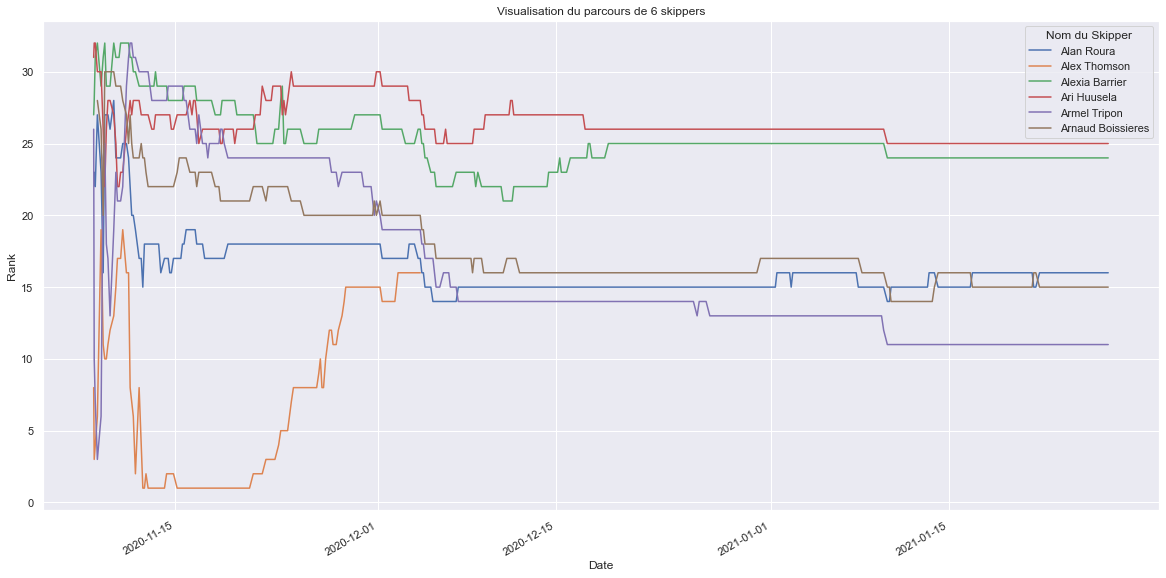

In [742]:
vg_tmp=pd.pivot_table(vg_merged,values='Rank',columns='Nom du Skipper',index='Date')
vg_tmp.iloc[:,0:6].plot(figsize=(20, 10));
plt.ylabel("Rank")
plt.title("Visualisation du parcours de 6 skippers")

vg_tmp

**Visualisation du rang en fonction du déplacement du poids par le voilier**

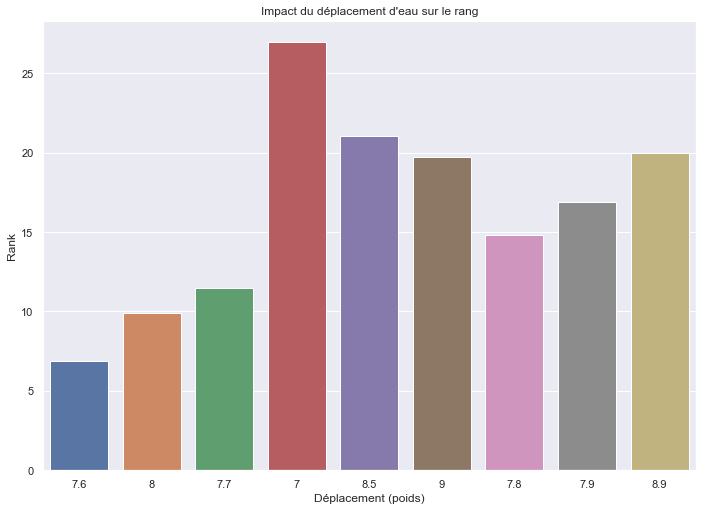

<function seaborn.categorical.barplot(*, x=None, y=None, hue=None, data=None, order=None, hue_order=None, estimator=<function mean at 0x000001A320A07790>, ci=95, n_boot=1000, units=None, seed=None, orient=None, color=None, palette=None, saturation=0.75, errcolor='.26', errwidth=None, capsize=None, dodge=True, ax=None, **kwargs)>

In [743]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x="Déplacement (poids)", y="Rank", data=vg_merged, ci=None)
plt.title("Impact du déplacement d'eau sur le rang")
plt.show()

sns.barplot

**Impact du foil sur la VMG Last Report moyenne**

In [746]:
vg_tmp= vg_merged.groupby(['Nombre de dérives']).agg({'Nom du Skipper': lambda x: x.nunique(), 'VMG last report_kts': np.mean, 'Vitesse last report_kts': np.mean, 'Distance last report_nm': np.mean, 'Rank' : np.mean})

vg_tmp



,Nom du Skipper,VMG last report_kts,Vitesse last report_kts,Distance last report_nm,Rank
Nombre de dérives,,,,,
2,13,10.977294,12.254540,54.562006,17.171101
2 asymétriques,1,10.325519,11.923651,53.156846,21.029046
foils,19,11.861425,13.576268,61.411567,12.369801


Text(0.5, 1.0, 'Impact du Foils sur le rang')

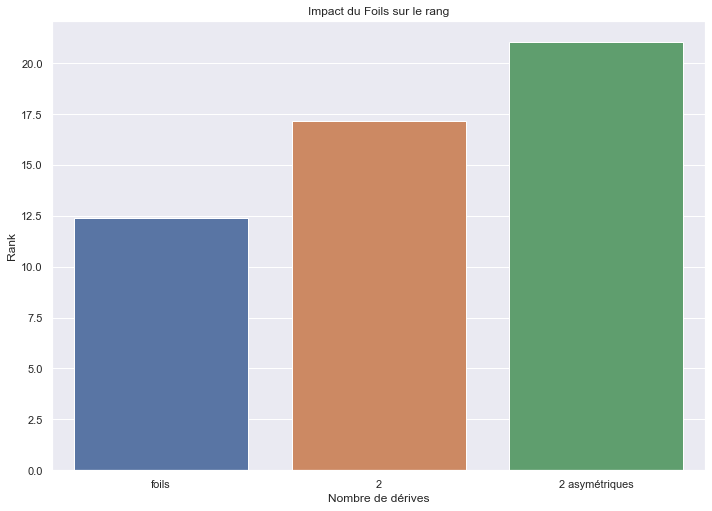

In [745]:
sns.barplot(x="Nombre de dérives", y="Rank", data=vg_merged, ci=None)
plt.title("Impact du Foils sur le rang")

Les voiliers équipés de foils semblent avoir un avantage car le rang moyen est le plus bas comparé aux autres voiliers.

**Corrélation et régression linéaire entre le rang moyen et la VMG last report jusqu'au 27 Janvier**

<AxesSubplot:title={'center':'Régression linéaire entre le rang moyen et la VMG'}, xlabel='VMG last report_kts', ylabel='Rank'>

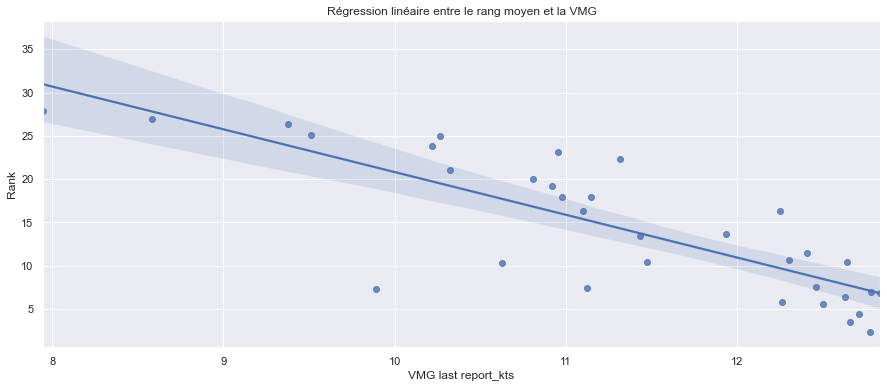

In [770]:
#Régression entre la VGM moyenne (VMG last report) et le Rang moyen
vg_temp = vg_merged.groupby(['Nom du Skipper']).agg({'VMG last report_kts': np.mean , 'Rank':np.mean})
vg_temp.reset_index(inplace=True)
fig = plt.figure(figsize=(15,6))
plt.title("Régression linéaire entre le rang moyen et la VMG")
sns.regplot(data=vg_temp, x='VMG last report_kts', y='Rank')

D'après le graphique, la VMG a un certain impact sur le rang moyen des skippers.


**Affichage du parcours de Yannick Bestaven, vainqueur de la course**

In [757]:
vg_Bestaven = vg[vg["Nom du Skipper"] == "Yannick Bestaven"]

df1 = vg_Bestaven[['Latitude','Longitude']]
points_1 = [tuple(x) for x in df1.to_numpy()]

circuits_map = folium.Map(location = [-3.3328523224277045, -19.89264564334541], zoom_start=2)
#add a markers
for each in points_1:  
    folium.Marker(each, 
    icon=folium.Icon(color='blue', prefix='fa', icon='flag-checkered')).add_to(circuits_map)

circuits_map